In [1]:
import chess
import chess.pgn
import time
import numpy as np
from io import StringIO
from tqdm import tqdm
import torch

In [2]:
with open("data/raw/100k.pgn", "r") as f:
    lines = [line for line in f.readlines() if line[0] == "1"]

In [3]:
piece_dict = {
    '.': 0, 'p': 1, 'n': 2, 'b': 3, 'k': 4, 'r': 5, 'q': 6, 'P': 7, 'N': 8, 'B': 9, 'K': 10, 'R': 11, 'Q': 12
}

In [4]:
def board_to_tensor(board):
    return torch.tensor([[piece_dict[p] for p in row.split(" ")] for row in str(board).split("\n")])

In [5]:
def get_board_tensor(pgn_str):
    pgn = StringIO(pgn_str)
    game = chess.pgn.read_game(pgn)
    board = chess.Board()

    boardTensor = []
    
    new_str = ""
    # Iterate across the game stopping at random points to sample different squares
    for i, move in enumerate(game.mainline_moves()):
        if i % 2 == 0:
            new_str += f"{i//2}."
        new_str += board.san(move) + " "
        board.push(move)
        boardTensor.append(board_to_tensor(board))

    return new_str, torch.stack(boardTensor, axis=0)

In [6]:
new_str, board_tensor = get_board_tensor(lines[0])
print(new_str)
print(board_tensor.shape)

0.e4 e6 1.d4 b6 2.a3 Bb7 3.Nc3 Nh6 4.Bxh6 gxh6 5.Be2 Qg5 6.Bg4 h5 7.Nf3 Qg6 8.Nh4 Qg5 9.Bxh5 Qxh4 10.Qf3 Kd8 11.Qxf7 Nc6 12.Qe8# 
torch.Size([25, 8, 8])


In [7]:
# Grab a subset of the line for faster iteration
# lines = lines[:1_000]

In [8]:
X = []
Y = []
for line in tqdm(lines):
    new_str, board_tensor = get_board_tensor(line)
    X.append(new_str)
    Y.append(board_tensor)

lines = X
boards = Y

100%|██████████| 121332/121332 [25:00<00:00, 80.83it/s] 


In [9]:
vocab = set()
for line in X:
    for c in line:
        vocab.add(c)

itos = {i:c for i, c in enumerate(vocab)}
stoi = {c:i for i, c in itos.items()}

In [10]:
# Dump vocab

import pickle
with open("data/preprocessed/100k/vocab.pkl", "wb") as f:
    pickle.dump((vocab, itos, stoi), f)

In [11]:
def char_encode(inp):
    if isinstance(inp, str):
        return torch.tensor([stoi[c] for c in inp])
    else:
        return [char_encode(line) for line in inp]

In [12]:
def create_datasets(lines, boards, stoi, bptt=64, val_split=.125, test_split=.125):
    X = []
    Y = []

    for line, board in tqdm(zip(lines, boards), total=len(lines)):
        if len(line) < bptt:
            line = line + "." * (bptt - len(line))
            # Pad out with random char.  Will get ignored since no more spaces

        line = char_encode(line[:bptt])
        X.append(line)
        n_spaces = len(torch.argwhere(line == stoi[" "]).flatten())
        Y.append(board[:n_spaces])

    X = torch.stack(X)
    
    train_end = int(len(X)*(1-(val_split+test_split)))
    val_end = int(len(X)*(1-test_split))

    X_train = X[:train_end]
    X_valid = X[train_end:val_end]
    X_test = X[val_end:]

    Y_train = Y[:train_end]
    Y_valid = Y[train_end:val_end]
    Y_test = Y[val_end:]

    return (X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test)

In [13]:
bptt = 256

# Y_train is list of tensors w/ board positions after each move
# X_train is tensor of tokenized games

(X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test) = create_datasets(lines, boards, stoi, bptt=bptt)

100%|██████████| 121332/121332 [00:12<00:00, 9795.25it/s] 


In [20]:
def dump_data(x, y, path):
    torch.save(x, path+'_x.pt')
    torch.save(torch.cat(y), path+'_y.pt')
    torch.save(torch.tensor([len(l) for l in y]), path+'_lens.pt')

def load_data(path):
    x = torch.load(path+'_x.pt')
    y = torch.load(path+'_y.pt')
    lens = torch.load(path+'_lens.pt')

    idx = torch.cat([torch.tensor([0]), torch.cumsum(lens, 0)])

    y = [y[idx[i]:idx[i+1]] for i in range(len(idx)-1)]

    return x, y

In [21]:
sets = {
    "train": (X_train, Y_train),
    "valid": (X_valid, Y_valid),
    "test": (X_test, Y_test),
}

for name, (x, y) in sets.items():
    dump_data(x, y, f"data/preprocessed/100k/{name}")

### Verify that saving and loading works

In [18]:
x, y = load_data("data/preprocessed/100k/train")

In [19]:
print(torch.equal(x, X_train))
print(all(torch.equal(i, j) for i, j in zip(Y_train, y)))

True
True


(array([1.6874e+04, 4.6755e+04, 3.5538e+04, 1.5788e+04, 5.0360e+03,
        1.0390e+03, 2.0600e+02, 7.7000e+01, 1.5000e+01, 4.0000e+00]),
 array([   8.,  182.,  356.,  530.,  704.,  878., 1052., 1226., 1400.,
        1574., 1748.]),
 <BarContainer object of 10 artists>)

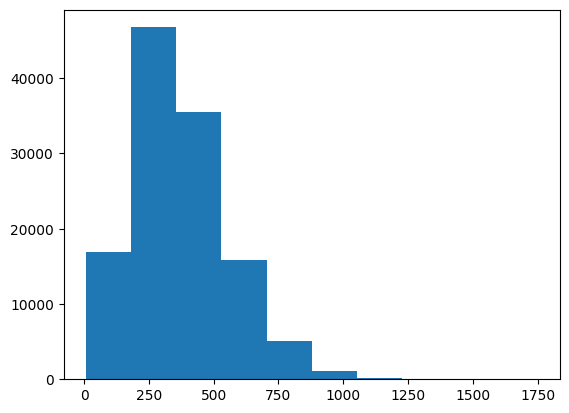

In [24]:
import matplotlib.pyplot as plt
plt.hist([len(line) for line in lines])